# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

The data is on the github repo. Each file is the economic census for 1 year. 
Download it programmatically and move it to PUIdata

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


## You can use zipfile module in python to unzip the files
it should be installed in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands)

In [10]:
import pandas as pd
import zipfile 
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pylab as plt
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import zipfile
import os
#zf = zipfile.ZipFile(fname)
#df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 248


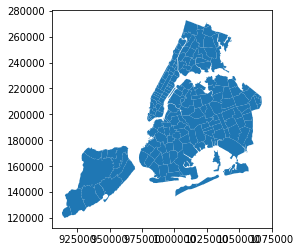

In [11]:
import geopandas as gp
nyczipsshp = gp.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")

nyczipsshp.drop_duplicates("ZIPCODE").plot()

print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp['ZIPCODE'].unique().astype(int)
print("number of NYC zip codes:", len(nyczips))

In [79]:
os.getenv("PUIDATA")

'/nfshome/jz3309/PUIdata'

In [98]:
zipfile94 = "zbp94totals.zip"
unzip94 = zipfile.ZipFile(os.getenv('PUIDATA')+'/'+"zbp/"+ zipfile94)
df94 = pd.read_csv(unzip94.open(zipfile94.replace('.zip','.txt')))
df94.head()

,zip,name,empflag,emp,qp1,ap,est
0,1001,"Agawam, MA",NaN,6198,33601,155158,439
1,1002,"Amherst, MA",NaN,6073,28924,127367,450
2,1003,"Amherst, MA",NaN,68,367,1604,10
3,1004,"Amherst, MA",NaN,210,844,4302,47
4,1005,"Barre, MA",NaN,678,3010,13521,92


In [103]:
cbs = pd.DataFrame()
for i in range (94,100):
    filename = 'zbp' + str(i) + 'totals.zip'
    zf = zipfile.ZipFile(os.getenv('PUIDATA')+'/'+'zbp/' + filename)
    df = pd.read_csv(zf.open(filename.replace('.zip','.txt')))
    df.columns = [x.lower() for x in df.columns]
    df['year'] = i + 1900
    
    cbs = cbs.append(df)

In [104]:
#The data I DOWNLOAD from fbb's github is from 1994.
for i in range (0,15):
    if i < 10:
        filename = 'zbp0' + str(i) + 'totals.zip'
        zf = zipfile.ZipFile(os.getenv('PUIDATA')+'/'+'zbp/'+ filename)
        df = pd.read_csv(zf.open(filename.replace('.zip','.txt')))
        df.columns = [x.lower() for x in df.columns]
        df['year'] = i + 2000
   
        cbs = cbs.append(df)
    else:
        filename = 'zbp' + str(i) + 'totals.zip'
        zf = zipfile.ZipFile( os.getenv('PUIDATA')+'/'+'zbp/'+ filename)
        df = pd.read_csv(zf.open(filename.replace('.zip','.txt')))
        df.columns = [x.lower() for x in df.columns]
        df['year'] = i + 2000

        cbs = cbs.append(df)

In [105]:
cbs.reset_index(inplace = True)
cbs.drop('index', axis = 1, inplace = True)
cbs = cbs[cbs['zip'].isin(nyczips)]
cbs = cbs[['zip', 'est', 'year']]
cbs.head()

,zip,est,year
2966,10001,6999,1994
2967,10002,1784,1994
2968,10003,3256,1994
2969,10004,1115,1994
2970,10005,1076,1994


In [106]:
cbs.shape

(5019, 3)

In [107]:
pivot = cbs.pivot(index = 'zip', columns = 'year', values = 'est')
pivot.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
10001,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0,7317.0,7188.0,7141.0,7084.0,...,7312.0,7415.0,7549.0,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0
10002,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0,2277.0,2543.0,2269.0,2402.0,...,2682.0,2686.0,2685.0,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0
10003,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0,3683.0,3602.0,3616.0,3704.0,...,3867.0,3909.0,4049.0,4071.0,4099.0,4113.0,4159.0,4214.0,4277.0,4333.0
10004,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,1252.0,...,1260.0,1311.0,1370.0,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0
10005,1076.0,1109.0,1216.0,1227.0,1270.0,1242.0,1287.0,1249.0,1244.0,1200.0,...,1214.0,1259.0,1273.0,1291.0,1274.0,1266.0,1301.0,1273.0,1296.0,1321.0


In [73]:
cbs['zip'].unique().shape

(245,)

In [74]:
# 20 years of data and 263 zipcodes-- in my dataframe, I did not get 263 zipcodes only 245
cbs.shape

(5019, 3)

In [75]:
pivot.shape

(245, 21)

In [22]:
cleancsb = pivot.dropna()

In [23]:
#cleaning all missing values
cleancsb.shape

(230, 21)

In [24]:
#then the standardization will look like:
vals = ((cleancsb.T - cleancsb.mean(1)) / cleancsb.std(1)).T
vals.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,0.432324,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986
10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.522100,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077
10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.127855,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945
10005,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,-0.496872,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888


In [25]:
vals.std(axis=1)

zip
10001    1.0
10002    1.0
10003    1.0
10004    1.0
10005    1.0
10006    1.0
10007    1.0
10009    1.0
10010    1.0
10011    1.0
10012    1.0
10013    1.0
10014    1.0
10016    1.0
10017    1.0
10018    1.0
10019    1.0
10020    1.0
10021    1.0
10022    1.0
10023    1.0
10024    1.0
10025    1.0
10026    1.0
10027    1.0
10028    1.0
10029    1.0
10030    1.0
10031    1.0
10032    1.0
        ... 
11385    1.0
11411    1.0
11412    1.0
11413    1.0
11414    1.0
11415    1.0
11416    1.0
11417    1.0
11418    1.0
11419    1.0
11420    1.0
11421    1.0
11422    1.0
11423    1.0
11426    1.0
11427    1.0
11428    1.0
11429    1.0
11430    1.0
11432    1.0
11433    1.0
11434    1.0
11435    1.0
11436    1.0
11451    1.0
11691    1.0
11692    1.0
11693    1.0
11694    1.0
11697    1.0
dtype: float64

vals.mean(axis=1) should return 0 (or something very small) everywhere

vals.mean(axis=1).shape should be (260,)

vals.std(axis=1) should return 1 everywhere

vals.std(axis=1).shape

## Kmeans  

In [26]:
#cluster with kmeans
import sklearn.cluster
import geopandas as gdp
import sklearn.cluster
from sklearn.cluster import DBSCAN
from scipy.cluster.vq import kmeans2
import scipy.cluster as scp
nc = 5

km = sklearn.cluster.KMeans(n_clusters=nc, random_state=444).fit(vals)
vals['kmlabels'] = km.labels_
vals.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,kmlabels
zip,,,,,,,,,,,,,,,,,,,,,
10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,0
10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,0
10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,2
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,2
10005,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888,0


In [27]:
km.labels_.shape

(230,)

In [28]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
#km.labels_.shape

In [29]:
km.cluster_centers_

array([[-1.87515281, -1.56134551, -1.31713919, -0.92280085, -0.78734841,
        -0.59957887, -0.44217988, -0.44766376,  0.01524826,  0.24518878,
         0.55721582,  0.58491892,  0.65357186,  0.67185731,  0.64580097,
         0.59893487,  0.64281373,  0.71881974,  0.71459262,  0.85971017,
         1.04453623],
       [ 1.26132321,  1.33345523,  1.19285401,  1.0175505 ,  0.90377145,
         0.95570788,  0.86969699,  0.30340269, -0.14995278, -0.48798146,
        -0.49514242, -0.50157118, -0.57417304, -0.32462755, -0.54933889,
        -0.56983899, -0.6235375 , -0.86393959, -0.87855379, -0.89493146,
        -0.92417331],
       [-1.29171708, -1.23656973, -1.12836582, -1.00145662, -0.89209644,
        -0.84798365, -0.73588268, -0.63646533, -0.30538507, -0.18205714,
        -0.02842321,  0.10543359,  0.13552818,  0.34450623,  0.47598443,
         0.61261489,  0.88496644,  1.06095307,  1.29723939,  1.57510731,
         1.79406921],
       [ 1.19436412,  0.70448178,  0.10289564, -0.29593812

### plot

In [30]:
vals = vals.iloc[:,:21]
vals.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,0.432324,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986
10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.522100,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077
10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.127855,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945
10005,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,-0.496872,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888


In [31]:
nc = 5
km5 = KMeans(random_state=111,n_clusters=nc)
fit = km5.fit(vals)
vals['kmlabels'] = fit.labels_
vals.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,kmlabels
zip,,,,,,,,,,,,,,,,,,,,,
10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,4
10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,4
10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,1
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,1
10005,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888,4


In [32]:
nyczipsshp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [33]:
nyczipsshp.columns

Index(['ZIPCODE', 'BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE',
       'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN',
       'geometry'],
      dtype='object')

In [34]:
plotdata = pd.DataFrame(vals['kmlabels'])
plotdata['ZIPCODE'] = plotdata.index
plotdata.head()

,kmlabels,ZIPCODE
zip,,
10001,4,10001
10002,4,10002
10003,1,10003
10004,1,10004
10005,4,10005


In [35]:
nyczipsshp.dtypes

ZIPCODE        object
BLDGZIP        object
PO_NAME        object
POPULATION    float64
AREA          float64
STATE          object
COUNTY         object
ST_FIPS        object
CTY_FIPS       object
URL            object
SHAPE_AREA    float64
SHAPE_LEN     float64
geometry       object
dtype: object

In [36]:
nyczipsshp['ZIPCODE'] = nyczipsshp['ZIPCODE'].astype(int)



In [37]:
clustermap = nyczipsshp.merge(plotdata, on = 'ZIPCODE',how='inner')
clustermap.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,kmlabels
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",1
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",1
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",1
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",1
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",1


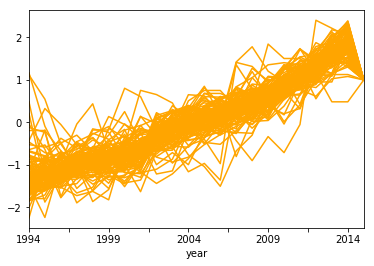

In [38]:
#try to plot one cluster 
#cluster=1
clustertest = vals[vals['kmlabels']== 1][:-1]
clustertest.head()
clustertest.T.plot(c='orange',legend=False)

In [39]:
vals.transpose()[:-1].index.astype(int)-1994

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
            19, 20],
           dtype='int64', name='year')

(905410.75604293647,
 1075212.5382562785,
 112386.35181947275,
 280345.45402395498)

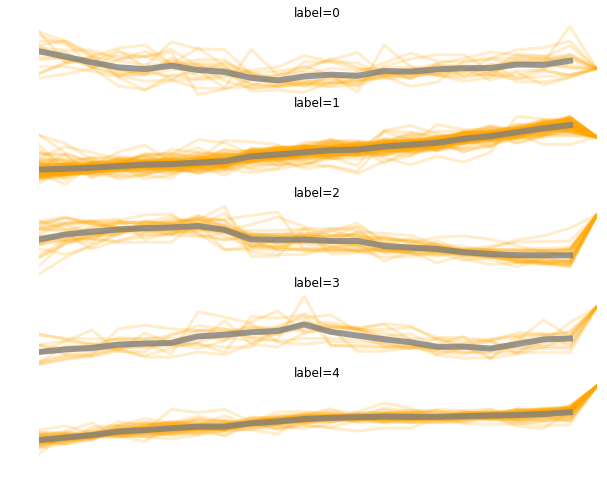

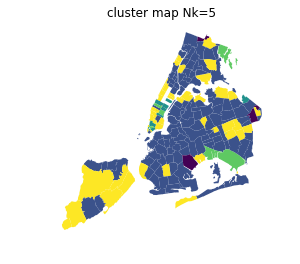

In [40]:
fig = plt.figure(figsize=(10,8))
values = [int(k) for k in vals.columns[0:-1]]
year=1994

for i in range(nc):
    ax = fig.add_subplot(5,1,i+1)
    vals[vals['kmlabels']==i][:-1].transpose().plot(color='orange',alpha=0.2,legend=False,ax=ax,linewidth=3)
    
    plt.plot(vals.transpose()[:-1].index.astype(int)-year, km5.cluster_centers_[i],c='grey',linewidth=6,alpha=0.8)
    ax.set_title('label='+ str(i))
    ax.axis('off')
    


fig = plt.figure(3,figsize=(20,8))
clustermap.plot(column='kmlabels')
plt.title('cluster map Nk=5')
plt.axis('off')


Figure 1:
cloropleth of cluster centers for 5 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

### The map of the clusters may look something like this

//anaconda/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
//anaconda/lib/python2.7/site-packages/geopandas/plotting.py:229: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


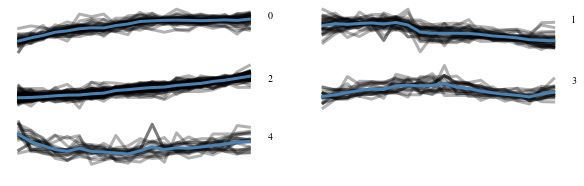

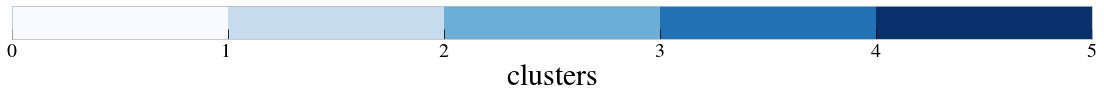

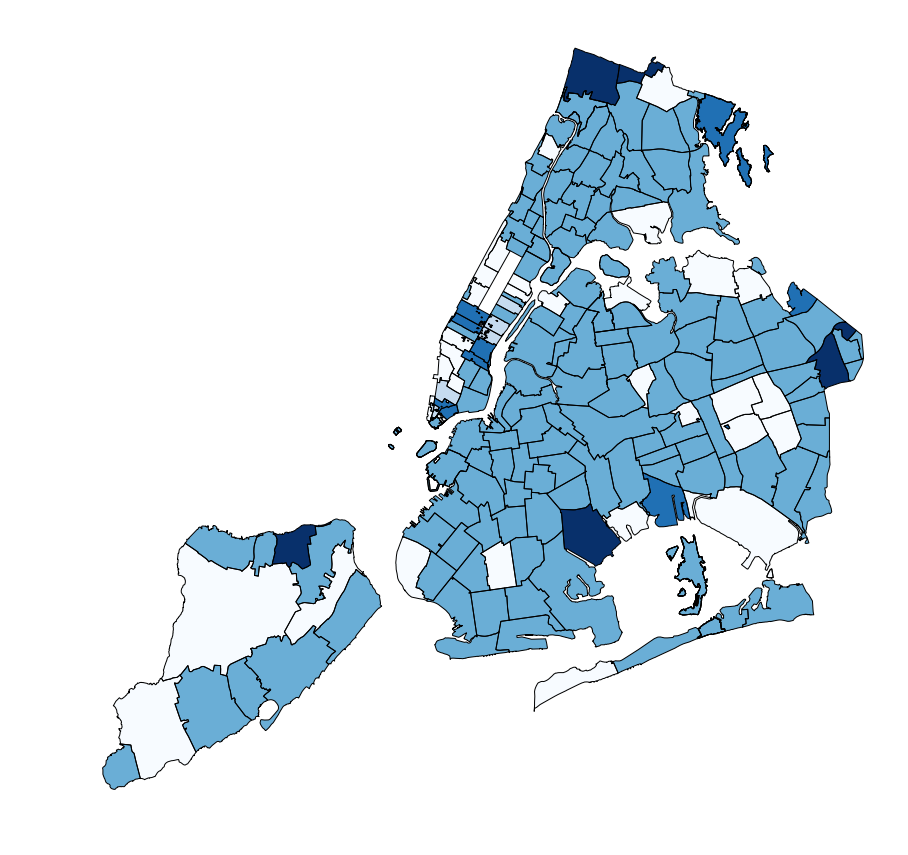

In [16]:
...

### Figure 3: 
cloropleth of  cluster centers for 5 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

### or maybe like this, depending on which algorithm you use, and how you proceed to preprocess your data and how you cluster it. There is no one correct answer, but general trends should be retrieved.

(905410.75604293647,
 1075212.5382562787,
 112386.35181947277,
 280345.45402395504)

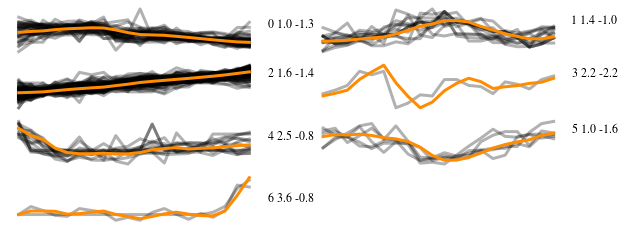

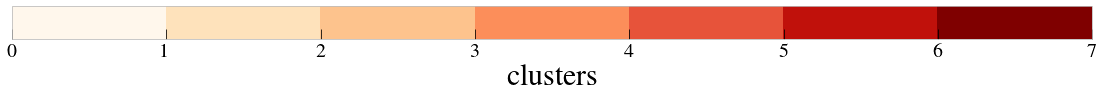

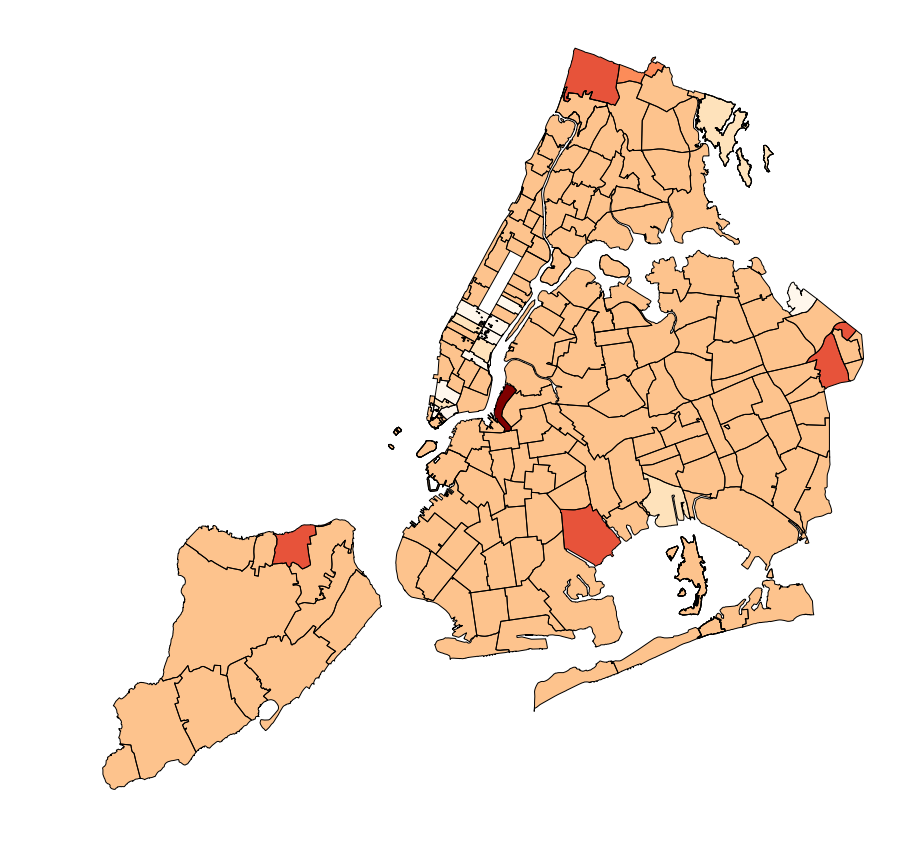

In [29]:
...

### Figure 9: 
As figures 3, 5, 7 for hierarchical agglomerative clustering in 7 clusters, with smoothed time series

# If you want to use agglomerative clustering

In [65]:
nc=5

agc = AgglomerativeClustering(n_clusters=nc).fit(vals)
labelsag = agc.labels_
centroidsag = np.zeros((nc, vals.shape[1]))
plotdata['labelsag'] = agc.labels_
plotdata.head()

,kmlabels,ZIPCODE,labelsag
zip,,,
10001,4,10001,4
10002,4,10002,4
10003,1,10003,2
10004,1,10004,2
10005,4,10005,4


In [42]:
agclustermap= nyczipsshp.merge(plotdata, on='ZIPCODE',how='inner')
agclustermap.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,kmlabels,labelsag
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",1,3
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",1,3
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",1,3
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",1,3
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",1,3


In [43]:
agc

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=5, n_components=None,
            pooling_func=<function mean at 0x7fea1015f840>)

In [44]:
vals2 = vals
vals2['labelsag'] = agc.labels_
vals2.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2007,2008,2009,2010,2011,2012,2013,2014,kmlabels,labelsag
zip,,,,,,,,,,,,,,,,,,,,,
10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,4,2
10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,4,2
10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,1,3
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,1,3
10005,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888,4,2


In [52]:
vals2.transpose()

zip,10001,10002,10003,10004,10005,10006,10007,10009,10010,10011,...,11433,11434,11435,11436,11451,11691,11692,11693,11694,11697
year,,,,,,,,,,,,,,,,,,,,,
1994,-1.839191,-1.713540,-1.820497,-1.512649,-2.819347,1.576901,-0.444220,-1.695218,-0.589198,-2.146355,...,-2.114934,-1.632651,-1.405005,-1.296083,-1.134733,-0.805023,-0.947361,-0.458450,-0.842815,-1.541458
1995,-1.193297,-1.626405,-1.434653,-1.438217,-2.263972,0.902719,-0.717132,-1.700614,-1.026701,-1.938151,...,-1.587098,-1.514780,-1.286312,-1.347340,-1.134733,-0.967353,-0.854828,-0.710477,-1.375564,-1.716434
1996,-1.287641,-1.377447,-1.307101,-1.363786,-0.463213,0.525634,-0.882533,-1.484761,-0.452478,-1.660546,...,-1.549396,-1.382175,-1.306094,-1.193568,-1.134733,-0.689073,-0.484696,-0.811288,-1.257175,-1.366482
1997,-0.714319,-1.053802,-0.930824,-1.032980,-0.278088,0.765597,-0.609621,-1.085433,0.682297,-0.865101,...,-1.134668,-0.792821,-1.276421,-1.296083,-0.218218,-0.851403,-0.299630,-1.063315,-0.842815,-0.666576
1998,0.011404,-1.168323,-0.567301,-1.008170,0.445582,1.222670,-0.650971,-0.874976,1.229177,-0.555464,...,-0.493724,-1.043297,-0.930233,-1.296083,-0.218218,-1.129683,-0.669762,-1.264937,-1.020398,-0.666576
1999,-0.140998,-0.964178,-0.535414,-0.536772,-0.025645,1.554047,-0.477300,-0.777842,1.106129,-0.208458,...,-0.342914,-0.925426,-0.950015,-0.937280,-0.218218,-1.106493,-0.299630,-1.264937,-1.434758,-0.666576
2000,0.468610,-0.486179,-0.458882,-0.032293,0.731684,1.645462,-0.278819,-0.475648,1.926448,-0.267182,...,-0.606832,-0.674951,-0.742302,-0.578478,0.698297,-1.384773,0.255567,-1.264937,-1.197981,-0.491600
2001,-0.467573,0.176049,-0.717175,-0.420990,0.092162,1.176962,-1.056204,-0.427081,1.584648,-0.592834,...,-0.493724,-0.262403,-0.712629,-0.988538,1.614812,-0.967353,-0.484696,-0.760883,-0.428454,-0.316624
2002,-0.808663,-0.506095,-0.672532,-0.371369,0.008014,0.125695,2.144307,-0.146472,0.313154,-0.112364,...,0.411137,-0.115064,-0.396114,0.087870,1.614812,-0.619504,-0.114565,-0.508855,-0.369260,-0.841553


In [60]:
#vals2['labelsag'].astype(float)
aggro

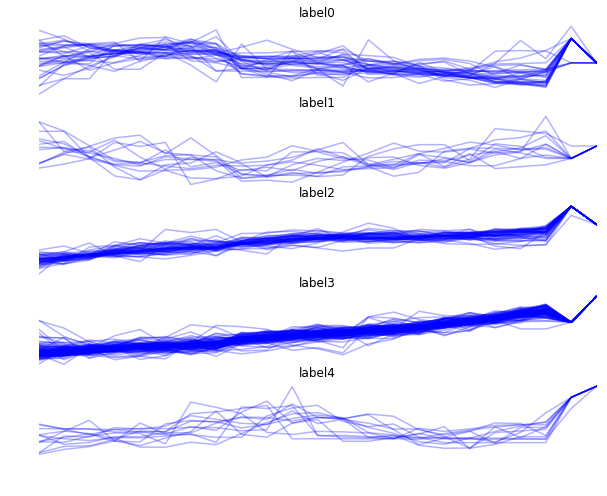

In [67]:
fig = plt.figure(figsize=(10,8))
year = [int(j) for j in vals2.columns[0:-2]]
for i in range(5):
    ax = fig.add_subplot(5,1,i + 1)
    vals2[vals2['labelsag'] == i][:-1].T.plot(legend=False, ax=ax, color = 'blue', alpha = 0.3)
    ax.axis('off')
    ax.set_title('label'+str(i))

Figure 2: The figures above show time sereis resulted by agglomerative clustering with 5 clusters.

Text(0.5,1,'Cluste centers for 5 agglomerative clusters')

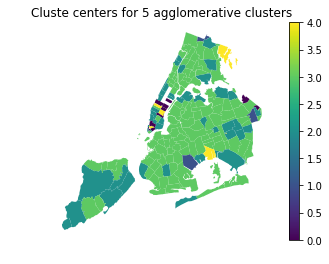

In [47]:
fig = plt.figure(figsize=(10,8))
agclustermap.plot(column='labelsag',legend=True)
plt.axis('off')
plt.title('Cluste centers for 5 agglomerative clusters')

Figure3: Agglomerative clustering with nc=5 overlayed on the nyc zipcode map.Compare with the Kmeans resutls, two clustering algorithms are mostly give the same clustering outcome with 5 clusters.

### And if you use hierarchical clustering in scipy you can make a dandrogram it may look like this:

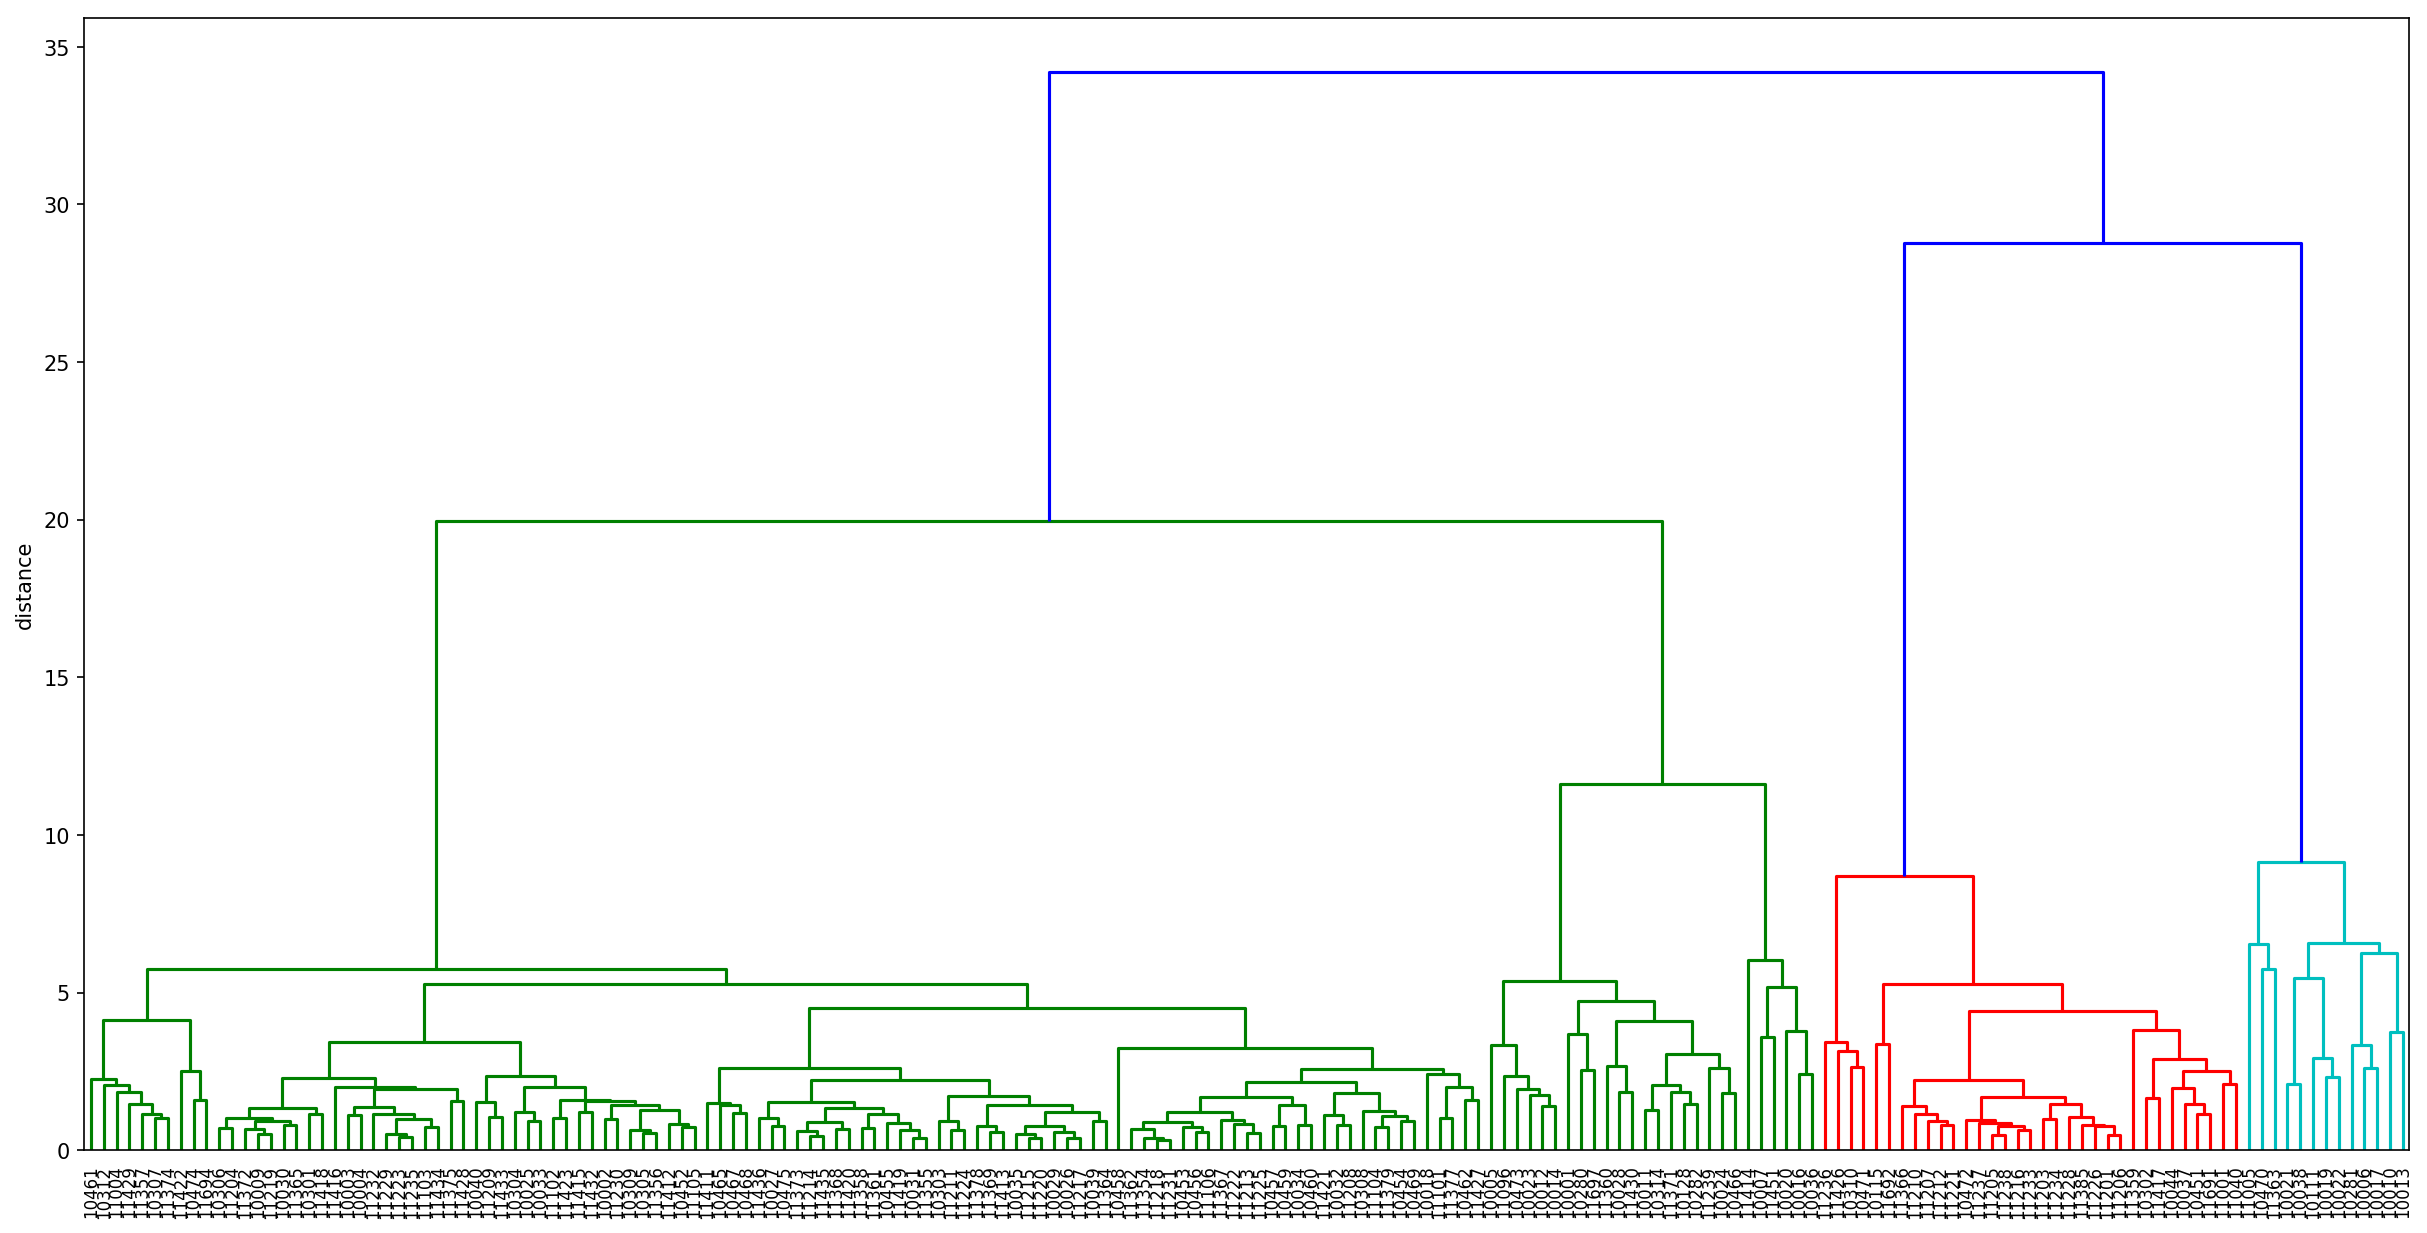

In [617]:
import scipy.cluster as scp
fig = plt.figure(figsize=(20,10), dpi=150)
plt.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals, method='ward'),
                               labels = vals.index.values,
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8.)  # font size for the x axis labels)


Figure4:  A dandrogram of bureau business data from 1994 to 2014 by useing the hierarchical clustering.

In [20]:
!pwd

/nfshome/fb55/PUI2017_fb55/HW11_fb55
